## Общие выводы и этапы работы с признаками:
#### 1) Нормализовал признаки - метод StandardScaler.
#### 2) Удалил явно коррелированные.
#### 3) Удалил все строки с NaN.
Результат работы алгоритма низкий, поскольку осталось очень мало строк.
Алгоритму не обучиться всем закономерностям исходного датасета.
#### 4) По очереди менял NaN на ноль, медиану, среднее значение.
Результат стал гораздо лучше - выросли все основные метрики precision, recall, f1, roc_auc.
Разница между разными заменами NaN не значительная в качестве.
#### 5) Сбалансировал минорный класс, рандомно добавил меньшего класса - метод RandomOverSampler.
Резко вырос recall и roc_auc, но упала метрика precision и вместе с ней f1.
Можно менять порог классификатора, таким образом балансируя в зависимости от смысла задачи между recall и precision.
#### 6) Избавился от выбросов - метод LocalOutlierFactor.
Результат стал сально хуже.

- По итогу - вместо удаления NaN в данном датасете нужно их менять на ноль, медиану или среднее, т.к. удаление ведет к резкому уменьшению выборки. Так же имеет смысл сбалансировать минорный класс и затем менять порог классификатора. Категориальных признаков замечено не было, везде присутсвуют числа, и кроме того признаки асбтрактны не ясно , что обозначают.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Загружаем данные - они уже предварительно разбиты на train и test
df_train = pd.read_csv("aps_failure_training_set.csv", header = 14)
df_test = pd.read_csv("aps_failure_test_set.csv", header = 14)

In [3]:
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [4]:
# Все кроме одного определяются, как object
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [5]:
df_train.dtypes

class     object
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
           ...  
ee_007    object
ee_008    object
ee_009    object
ef_000    object
eg_000    object
Length: 171, dtype: object

In [6]:
# Количество классов на трейне
df_train['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [7]:
# Количество классов на тесте
df_test['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

In [8]:
# Меняем в целевой переменной 'class' строковые значения на бинарные
df_train['class'] = df_train['class'].apply(lambda x: 1 if x=='pos' else 0)
df_test['class'] = df_test['class'].apply(lambda x: 1 if x=='pos' else 0)

In [9]:
# Принудительно переводим в числовой тип данных object
df_train = df_train.apply(pd.to_numeric, errors='coerce')
df_test = df_test.apply(pd.to_numeric, errors='coerce')

In [10]:
# Признаки с самым больщим количеством NaN, но и в них часть определилась как числа, 
# т.е. все признаки признаем числовыми, поскольку нам про них ничего не известно - они абстрактные.
df_train.isnull().sum().sort_values(ascending=False)[:10]

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
cr_000    46329
ab_000    46329
bn_000    44009
bm_000    39549
bl_000    27277
bk_000    23034
dtype: int64

In [11]:
# Основные статистики трейна
df_train.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,...,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,0.128020,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,...,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,8.340000e+02,0.000000,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.936000e+03,1.166000e+03,2.700000e+03,3.584000e+03,5.120000e+02,1.100000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000,3.077600e+04,0.000000,1.520000e+02,1.260000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,2.337960e+05,1.120860e+05,2.215180e+05,1.899880e+05,9.243200e+04,4.109800e+04,3.812000e+03,0.000000e+00,0.000000,0.000000
75%,0.000000,4.866800e+04,0.000000,9.640000e+02,4.300000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.383960e+05,2.182320e+05,4.666140e+05,4.032220e+05,2.750940e+05,1.678140e+05,1.397240e+05,2.028000e+03,0.000000,0.000000
max,1.000000,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


In [12]:
# Основные статистики теста
df_test.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,16000.000000,1.600000e+04,3637.000000,1.507400e+04,12019.000000,15310.000000,15310.000000,15811.000000,1.581100e+04,1.581100e+04,...,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,15238.000000,15238.000000
mean,0.023438,6.799698e+04,0.772065,3.580393e+08,439.498794,6.428347,10.195950,120.858516,2.064204e+03,1.379236e+04,...,4.649135e+05,2.212010e+05,4.690886e+05,4.256696e+05,3.559239e+05,3.524014e+05,1.442759e+05,8.560355e+03,0.064969,0.242683
std,0.151293,5.035350e+05,2.589224,7.966968e+08,1551.328109,118.186469,167.260463,6454.660300,8.925778e+04,2.358405e+05,...,1.255197e+06,5.828691e+05,1.267550e+06,1.259560e+06,1.199544e+06,1.628545e+06,5.368225e+05,5.329946e+04,3.374657,14.339059
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000,9.280000e+02,0.000000,1.600000e+01,26.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,3.178000e+03,1.256000e+03,2.883500e+03,3.869500e+03,6.100000e+02,1.240000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,0.000000,3.098200e+04,0.000000,1.590000e+02,130.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,2.409860e+05,1.147800e+05,2.297080e+05,1.956510e+05,9.657000e+04,4.201300e+04,3.985000e+03,0.000000e+00,0.000000,0.000000
75%,0.000000,4.947900e+04,0.000000,1.003500e+03,430.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,...,4.391320e+05,2.189510e+05,4.714860e+05,4.034105e+05,2.790355e+05,1.699100e+05,1.389310e+05,1.907000e+03,0.000000,0.000000
max,1.000000,4.294967e+07,58.000000,2.130707e+09,87038.000000,11044.000000,14186.000000,736174.000000,1.047252e+07,1.914916e+07,...,5.382333e+07,2.207969e+07,4.859750e+07,5.604348e+07,4.215944e+07,4.747137e+07,1.718575e+07,4.570398e+06,340.000000,1720.000000


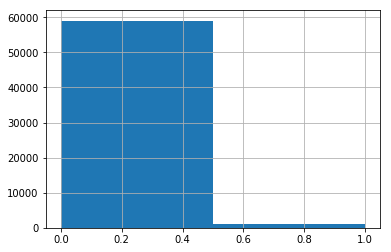

In [13]:
# Гистограмма рапределения целевой перменной на трейне
df_train['class'].hist(bins=2)
plt.show()

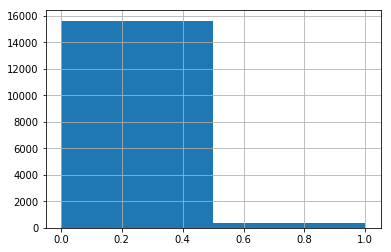

In [14]:
# Гистограмма рапределения целевой перменной на тесте
df_test['class'].hist(bins=2)
plt.show()

Обе выборки явно несбалансированные

<Figure size 864x720 with 0 Axes>

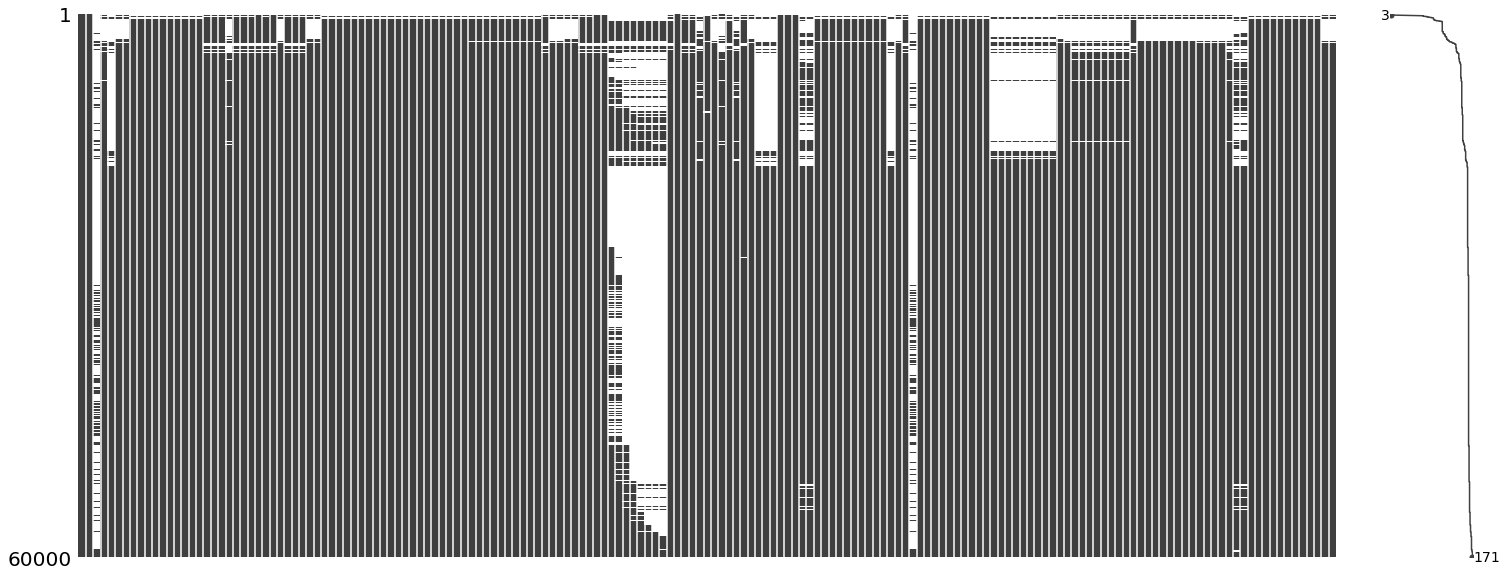

In [15]:
# Посмотрим на матрицу пустых значений NaN, по нектороым признакам их очень много
plt.figure(figsize=(12, 10))
msno.matrix(df_train, sort='ascending')
plt.show()

### Теперь поработаем с признаками

In [16]:
# Нормалиуем данные. Учимся на трейне, потом нормализуем сам трейн и тест.
scaler = StandardScaler()

v = list(set(df_train.columns) - set(["class"]))
scaler.fit(df_train[v])

df_train_scale = scaler.transform(df_train[v])
df_test_scale = scaler.transform(df_test[v])

df_train[v] = df_train_scale
df_test[v] = df_test_scale

In [17]:
# Удаляем самые скоррелированные признаки >=0.9, причем так, чтобы их удалилось наименьшее количество
Corr = df_train.drop(columns=['class']).corr()
CorField = list(combinations(Corr.columns, 2))
corr_pair = [(i[0], i[1], Corr.loc[i]) for i in CorField if abs(Corr.loc[i]) >= 0.9]
counter = Counter([i[0] for i in corr_pair]) + Counter([i[1] for i in corr_pair])
feature_remove = set([i[0] if counter[i[0]] >= counter[i[1]] else i[1] for i in corr_pair ])
feature  = list(set(df_train.columns) - feature_remove) 
df_train = df_train[feature]
df_test = df_test[feature]

In [18]:
# Видим, что более их не осталось(>=0.9)
Corr = df_train.drop(columns=['class']).corr()
CorField = list(combinations(Corr.columns, 2))
corr_pair = [(i[0], i[1], Corr.loc[i]) for i in CorField if abs(Corr.loc[i]) >= 0.9]
corr_pair

[]

In [19]:
# Перед первым обучением классификатора сделаем пробную выборку, удалив просто все строки с NaN
# В тесте NaN оставим и заменим нулями, поскольку не известно какие данные могут приходить в будущем, удалить в тесте все NaN было бы не честно
x_train_notnan = df_train.dropna().drop(columns=['class'])
y_train_notnan = df_train.dropna()[['class']]

x_test_notnan = df_test.fillna(0).drop(columns=['class'])
y_test_notnan = df_test[['class']]

In [20]:
# Увидим, что трейн очень сильно уменьшился, и вряд ли на нем можно обучить алгоритм всем закономерностям исходных данных
x_train_notnan.shape

(748, 131)

In [21]:
# Создаем датафрейм, куда будем собирать все метрики разных моделей
data_metrics = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [22]:
# Функция для сбора метрик и записи в датафрейм
def dataframe_metrics(x_train,y_train,x_test, y_test, name, proc = 0.5):
    LR = LogisticRegression()
    LR.fit(x_train, y_train)
    #y_pred = LR.predict(x_test)
    y_pred = (LR.predict_proba(x_test)[:,1] >proc).astype('int')
    data = pd.DataFrame({ 'accuracy': [metrics.accuracy_score(y_test, y_pred)],
            'precision': [metrics.precision_score(y_test, y_pred)], 
            'recall': [metrics.recall_score(y_test, y_pred)], 
            'f1': [metrics.f1_score(y_test, y_pred)], 
            'roc_auc': [metrics.roc_auc_score(y_test, y_pred)]
           }, index = [name])
    return pd.concat([data_metrics, data], axis=0)

In [23]:
# Результат не очень хороший, но всё же алгоритм не совсем угадывает классы, roc_auc = 0.75
data_metrics = dataframe_metrics(x_train_notnan, y_train_notnan, x_test_notnan,y_test_notnan, 'delete_nan')
data_metrics

,accuracy,precision,recall,f1,roc_auc
delete_nan,0.983437,0.706767,0.501333,0.586583,0.748171


In [24]:
# Теперь заменим NaN на нули
x_train_0nan = df_train.fillna(0).drop(columns=['class'])
y_train_0nan = df_train[['class']]

x_test_0nan = df_test.fillna(0).drop(columns=['class'])
y_test_0nan = df_test[['class']]

In [25]:
# Результат стал уже сильно лучше, вполне приемлемым - метрики выросли
data_metrics = dataframe_metrics(x_train_0nan, y_train_0nan, x_test_0nan, y_test_0nan, '0_nan')
data_metrics

,accuracy,precision,recall,f1,roc_auc
delete_nan,0.983437,0.706767,0.501333,0.586583,0.748171
0_nan,0.989750,0.860068,0.672000,0.754491,0.834688


In [26]:
# Заменим все NaN медианами
x_train_mediannan = df_train.fillna(df_train.median()).drop(columns=['class'])
y_train_mediannan = df_train[['class']]

x_test_mediannan = df_test.fillna(df_test.median()).drop(columns=['class'])
y_test_mediannan = df_test[['class']]

In [27]:
# Результат почти как с заменой на ноль
data_metrics = dataframe_metrics(x_train_mediannan, y_train_mediannan, x_test_mediannan,y_test_mediannan, 'median_nan')
data_metrics

,accuracy,precision,recall,f1,roc_auc
delete_nan,0.983437,0.706767,0.501333,0.586583,0.748171
0_nan,0.989750,0.860068,0.672000,0.754491,0.834688
median_nan,0.989187,0.845890,0.658667,0.740630,0.827893


In [28]:
# Заменим средними значениями
x_train_meannan = df_train.fillna(df_train.mean()).drop(columns=['class'])
y_train_meannan = df_train[['class']]

x_test_meannan = df_test.fillna(df_test.mean()).drop(columns=['class'])
y_test_meannan = df_test[['class']]

In [29]:
# Результат аналогичен с заменами NaN на ноль или медиану
data_metrics = dataframe_metrics(x_train_meannan, y_train_meannan, x_test_meannan,y_test_meannan, 'mean_nan')
data_metrics

,accuracy,precision,recall,f1,roc_auc
delete_nan,0.983437,0.706767,0.501333,0.586583,0.748171
0_nan,0.989750,0.860068,0.672000,0.754491,0.834688
median_nan,0.989187,0.845890,0.658667,0.740630,0.827893
mean_nan,0.989750,0.860068,0.672000,0.754491,0.834688


In [30]:
# Теперь поработаем с несбалансированностью классов, насемплируем рандомно минорного класса, 
# сделаем это с нулями вместо NaN, поскольку результат был такой же при прочих заменах, а на ноль всегда проще менять в тесте в том числе
X_train_sampled, y_train_sampled = RandomOverSampler().fit_resample(x_train_0nan, y_train_0nan['class'])

In [31]:
# Выборка увеличилась по строкам
X_train_sampled.shape

(118000, 131)

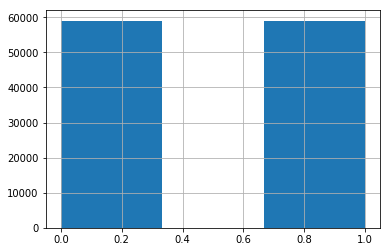

In [32]:
# Гистограмма показала, что классов стало одинаково
y_train_sampled.hist(bins=3)
plt.show()

In [33]:
# Видим, что резко вырос roc_auc и recall, но упал precision, а вместе с ним и f1
data_metrics = dataframe_metrics(X_train_sampled, y_train_sampled, x_test_mediannan,y_test_mediannan, 'random _sampler')
data_metrics

,accuracy,precision,recall,f1,roc_auc
delete_nan,0.983437,0.706767,0.501333,0.586583,0.748171
0_nan,0.989750,0.860068,0.672000,0.754491,0.834688
median_nan,0.989187,0.845890,0.658667,0.740630,0.827893
mean_nan,0.989750,0.860068,0.672000,0.754491,0.834688
random _sampler,0.975375,0.486787,0.933333,0.639854,0.954859


In [34]:
# Можно попробовать изменить порог классификатора с 0.5, на более высокий, 
# видно, что при более высоком пороге precision и f1 растет, и падает recall и roc_auc.
# Таким образом в зависмости от задачи - что более важно точность срабатывания или полнота, можно варьировать порог классификатора.
data_metrics = dataframe_metrics(X_train_sampled, y_train_sampled, x_test_mediannan,y_test_mediannan, 'random _sampler_0.98', proc = 0.98)
data_metrics

,accuracy,precision,recall,f1,roc_auc
delete_nan,0.983437,0.706767,0.501333,0.586583,0.748171
0_nan,0.989750,0.860068,0.672000,0.754491,0.834688
median_nan,0.989187,0.845890,0.658667,0.740630,0.827893
mean_nan,0.989750,0.860068,0.672000,0.754491,0.834688
random _sampler,0.975375,0.486787,0.933333,0.639854,0.954859
random _sampler_0.98,0.986875,0.702703,0.762667,0.731458,0.877461


In [35]:
# Теперь поработаем с выбросами
model_LOF = LocalOutlierFactor(n_neighbors=500)
outlier_indicator = model_LOF.fit_predict(x_train_0nan)
outlier_indicator

array([ 1,  1,  1, ...,  1, -1,  1])

In [36]:
# Удалим получившиеся выбросы из трейна
x_train_outlier = pd.concat([x_train_0nan, pd.DataFrame(outlier_indicator, columns = ['outlier_indicator'])], axis=1)
x_train_outlier = x_train_outlier[x_train_outlier['outlier_indicator']==1]
x_train_outlier = x_train_outlier.drop(columns=['outlier_indicator'])

y_train_outlier = pd.concat([y_train_0nan, pd.DataFrame(outlier_indicator, columns = ['outlier_indicator'])], axis=1)
y_train_outlier = y_train_outlier[y_train_outlier['outlier_indicator']==1]
y_train_outlier = y_train_outlier.drop(columns=['outlier_indicator'])

In [37]:
# Качество сильно просело, видимо, алгоритм потерял обобщающую способность на отфильтрованных данных от выбросов
data_metrics = dataframe_metrics(x_train_outlier, y_train_outlier, x_test_0nan,y_test_0nan, 'outlier', proc = 0.5)
data_metrics

,accuracy,precision,recall,f1,roc_auc
delete_nan,0.983437,0.706767,0.501333,0.586583,0.748171
0_nan,0.989750,0.860068,0.672000,0.754491,0.834688
median_nan,0.989187,0.845890,0.658667,0.740630,0.827893
mean_nan,0.989750,0.860068,0.672000,0.754491,0.834688
random _sampler,0.975375,0.486787,0.933333,0.639854,0.954859
random _sampler_0.98,0.986875,0.702703,0.762667,0.731458,0.877461
outlier,0.971250,0.425569,0.648000,0.513742,0.813504
